# Import

In [1]:
import os,sys
import datetime

#import time
import pandas as pd
import numpy as np

import scrublet as scr
import scipy.io

import anndata as ad

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import scanpy as sc
sc.logging.print_header()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13
Memory usage: current 0.15 GB, difference +0.05 GB


In [ ]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

plt.rcParams['figure.dpi']= 150

### Load data

In [5]:


home_dir = os.path.expanduser("~")
mother_folder = home_dir+"/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE"  # Replace with the path of your mother folder
include_string = "GeneFull/raw"  # Replace with the string to include
paths = find_file_directories("matrix.mtx", mother_folder, include_string)
if paths:
    [print(path) for path in paths]
else:
    print("matrix.mtx not found")




/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_68_S1/22_CASP_DB_68_S1_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_69_S2/22_CASP_DB_69_S2_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_70_S3/22_CASP_DB_70_S3_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_71_S4/22_CASP_DB_71_S4_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_72_S5/22_CASP_DB_72_S5_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_73_S6/22_CASP_DB_73_S6_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_DB_74_S7/22_CASP_DB_74_S7_Solo.out/GeneFull/raw
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/starsolo/22_CASP_

In [6]:
# empty list for storing adata files
lad = []

start = time.time()
for path in paths:
    
    # force slash at the end
    if path[-1] != "/":
        path = path + "/"
    
    # parse
    parsed = path.split("/")

    # extract library name
    name = parsed[-4]
    
    # laod to AnnData
    adata = sc.read(path + "matrix.mtx", cache = False)
    adata = adata.T

    adata.var = pd.read_csv(path  + "features.tsv", header = None, sep = "\t", usecols = [0, 1], names = ["gene_id", "gene_name"], dtype = {1 : str})
    adata.var.set_index("gene_name", inplace = True)
    adata.var.index.name = None
    adata.var_names_make_unique()
    #adata.var_names = pd.read_csv(path  + "features.tsv", header = None, sep = "\t", usecols = [1], dtype = {1 : str})[1]
    
    #adata.obs_names = pd.read_csv(path  + "barcodes_fix.csv",  header = None)[0]
    adata.obs["barcode"] = np.loadtxt(path + "barcodes.tsv", dtype = str)
    
    # add library
    adata.obs["library"] = name
    
    # append
    print(name, adata.shape)
    lad.append(adata)

    
print("%.1f min."%((time.time()-start)/60.))

# adata concat
adata = ad.concat(lad, merge = "same")
adata.obs_names = np.arange(adata.shape[0]).astype(str)


# trimming genome ref GRCh38
adata.var.rename(index = lambda s: s.split("_")[1], inplace = True)

22_CASP_DB_68_S1_Solo.out (884736, 37733)
22_CASP_DB_69_S2_Solo.out (884736, 37733)
22_CASP_DB_70_S3_Solo.out (884736, 37733)
22_CASP_DB_71_S4_Solo.out (884736, 37733)
22_CASP_DB_72_S5_Solo.out (884736, 37733)
22_CASP_DB_73_S6_Solo.out (884736, 37733)
22_CASP_DB_74_S7_Solo.out (884736, 37733)
22_CASP_DB_75_S8_Solo.out (884736, 37733)
22_CASP_DB_76_S9_Solo.out (884736, 37733)
22_CASP_DB_77_S10_Solo.out (884736, 37733)
12.1 min.


/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Filter on total counts and fraction mito

In [7]:
mitogenes = [i for i in adata.var_names if i.startswith("MT-")]

print(len(mitogenes))
mitogenes

13


['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [8]:
# get total counts and mito fraction

# total counts
adata.obs["total_counts"] = adata.X.sum(axis = 1)

# remove barcodes with 0 counts
cmask = adata.obs["total_counts"].values > 0
print(adata.shape)
adata = adata[cmask]
print(adata.shape)

# mito percentage
mitomask = np.in1d(adata.var_names, mitogenes)
adata.obs["pct_counts_mito"] = np.array(adata.X[:,mitomask].sum(axis=1)).T[0]/adata.obs["total_counts"].values*100.

(8847360, 37733)
(5223255, 37733)


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_1927/2512765380.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["pct_counts_mito"] = np.array(adata.X[:,mitomask].sum(axis=1)).T[0]/adata.obs["total_counts"].values*100.


In [9]:
adata.obs.head(3)

,barcode,library,total_counts,pct_counts_mito
2,ACAGGTCT_AAGTCCAGCC_AACAGGCT,22_CASP_DB_68_S1_Solo.out,1.0,0.0
4,ACCTCGCA_AAGTCCAGCC_AACAGGCT,22_CASP_DB_68_S1_Solo.out,1.0,0.0
5,ACCTGGTG_AAGTCCAGCC_AACAGGCT,22_CASP_DB_68_S1_Solo.out,2.0,0.0


### Select thresholds

In [10]:
renamer_library = {
    "22_CASP_DB_68_S1_Solo.out":"BB2.1",
    "22_CASP_DB_69_S2_Solo.out":"BB2.2",
    "22_CASP_DB_70_S3_Solo.out":"BB2.3",
    "22_CASP_DB_71_S4_Solo.out":"BB2.4",
    "22_CASP_DB_72_S5_Solo.out":"BB2.5",
    "22_CASP_DB_73_S6_Solo.out":"BB2.6",
    "22_CASP_DB_74_S7_Solo.out":"BB2.7",
    "22_CASP_DB_75_S8_Solo.out":"BB2.8",
    "22_CASP_DB_76_S9_Solo.out":"BB2.9",
    "22_CASP_DB_77_S10_Solo.out":"BB2.11"
}

adata.obs["library"] = [renamer_library[i] for i in adata.obs["library"]]

adata.obs.head(3)

,barcode,library,total_counts,pct_counts_mito
2,ACAGGTCT_AAGTCCAGCC_AACAGGCT,BB2.1,1.0,0.0
4,ACCTCGCA_AAGTCCAGCC_AACAGGCT,BB2.1,1.0,0.0
5,ACCTGGTG_AAGTCCAGCC_AACAGGCT,BB2.1,2.0,0.0


In [11]:
# Splitting barcode
adata.obs[["BC3", "BC2", "BC1"]] = adata.obs["barcode"].str.split("_", expand = True)


In [12]:
# Importing whitelists
bc1 = pd.read_csv("/Users/denis/microtechnologies/sequencing/whitelist/bc1.txt", names = ["bc1"])

In [13]:
# Demultiplexing 


GF_1_4_1 = bc1[0::12]
UL_1_10_2 = bc1[1::12]
UL_1_14_3 = bc1[2::12]
UL_5_24_4 = bc1[3::12]
GF_1_26_5 = bc1[4::12]
GF_1_27_6 = bc1[5::12]

KC_2_11_7 = bc1[6::12]
GF_2_12_8 = bc1[7::12]
UL_1_29_9 = bc1[8::12]
UL_1_32_10 = bc1[9::12]
GF_1_39_11 = bc1[10::12]
WBC5_12 = bc1[11::12]

columns = [
GF_1_4_1,
UL_1_10_2,
UL_1_14_3,
UL_5_24_4,
GF_1_26_5,
GF_1_27_6,
KC_2_11_7,
GF_2_12_8,
UL_1_29_9,
UL_1_32_10,
GF_1_39_11,
WBC5_12
]


In [17]:
# creating conditions for samples (columns)

values_columns = [
"GF, 1-FM02-NP0000004",
"UL, 1-FM02-NP0000010",
"UL, 1-FM02-NP0000014",
"UL, 5-FM02-NP0000024",
"GF, 1-FM02-NP0000026",
"GF, 1-FM02-NP0000027",
"KC, 2-FM02-NP0000011",
"GF, 2-FM02-NP0000012",
"UL, 1-FM02-NP0000029",
"UL, 1-FM02-NP0000032",
"GF, 1-FM02-NP0000039",
"KC, WBC5"
]


conditions_columns = [(adata.obs["BC1"].isin(condition["bc1"])) for condition in columns]

conditions = conditions_columns
values = values_columns

adata.obs["sample_code"] = np.select(conditions, values)

# Splitting sample
adata.obs[["sample", "code"]] = adata.obs["sample_code"].str.split(", ", expand = True)



In [21]:
libcol = "sample_code" # column of obs to use

# just a hack to faster fill-in thresholds used, they are set by eye
libs = adata.obs[libcol].unique()

#for entering threshold, copy/paste the output of this cell below
print("ts_dict = {") #for "threshold dictionary"
for lib in libs:
    print('"%s":(200,20), #(min_nr_genes,max_pct_mito)'%lib)
print('}')

ts_dict = {
"GF, 1-FM02-NP0000004":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000026":(200,20), #(min_nr_genes,max_pct_mito)
"KC, WBC5":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000039":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 5-FM02-NP0000024":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 2-FM02-NP0000012":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000014":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000027":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000029":(200,20), #(min_nr_genes,max_pct_mito)
"KC, 2-FM02-NP0000011":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000010":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000032":(200,20), #(min_nr_genes,max_pct_mito)
}


In [23]:
# copy and edit output of previous cell
# first run with any thresholds, then adjust based on the distribution of barcodes

ts_dict = {
"GF, 1-FM02-NP0000004":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000026":(200,20), #(min_nr_genes,max_pct_mito)
"KC, WBC5":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000039":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 5-FM02-NP0000024":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 2-FM02-NP0000012":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000014":(200,20), #(min_nr_genes,max_pct_mito)
"GF, 1-FM02-NP0000027":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000029":(200,20), #(min_nr_genes,max_pct_mito)
"KC, 2-FM02-NP0000011":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000010":(200,20), #(min_nr_genes,max_pct_mito)
"UL, 1-FM02-NP0000032":(200,20), #(min_nr_genes,max_pct_mito)
}



75328


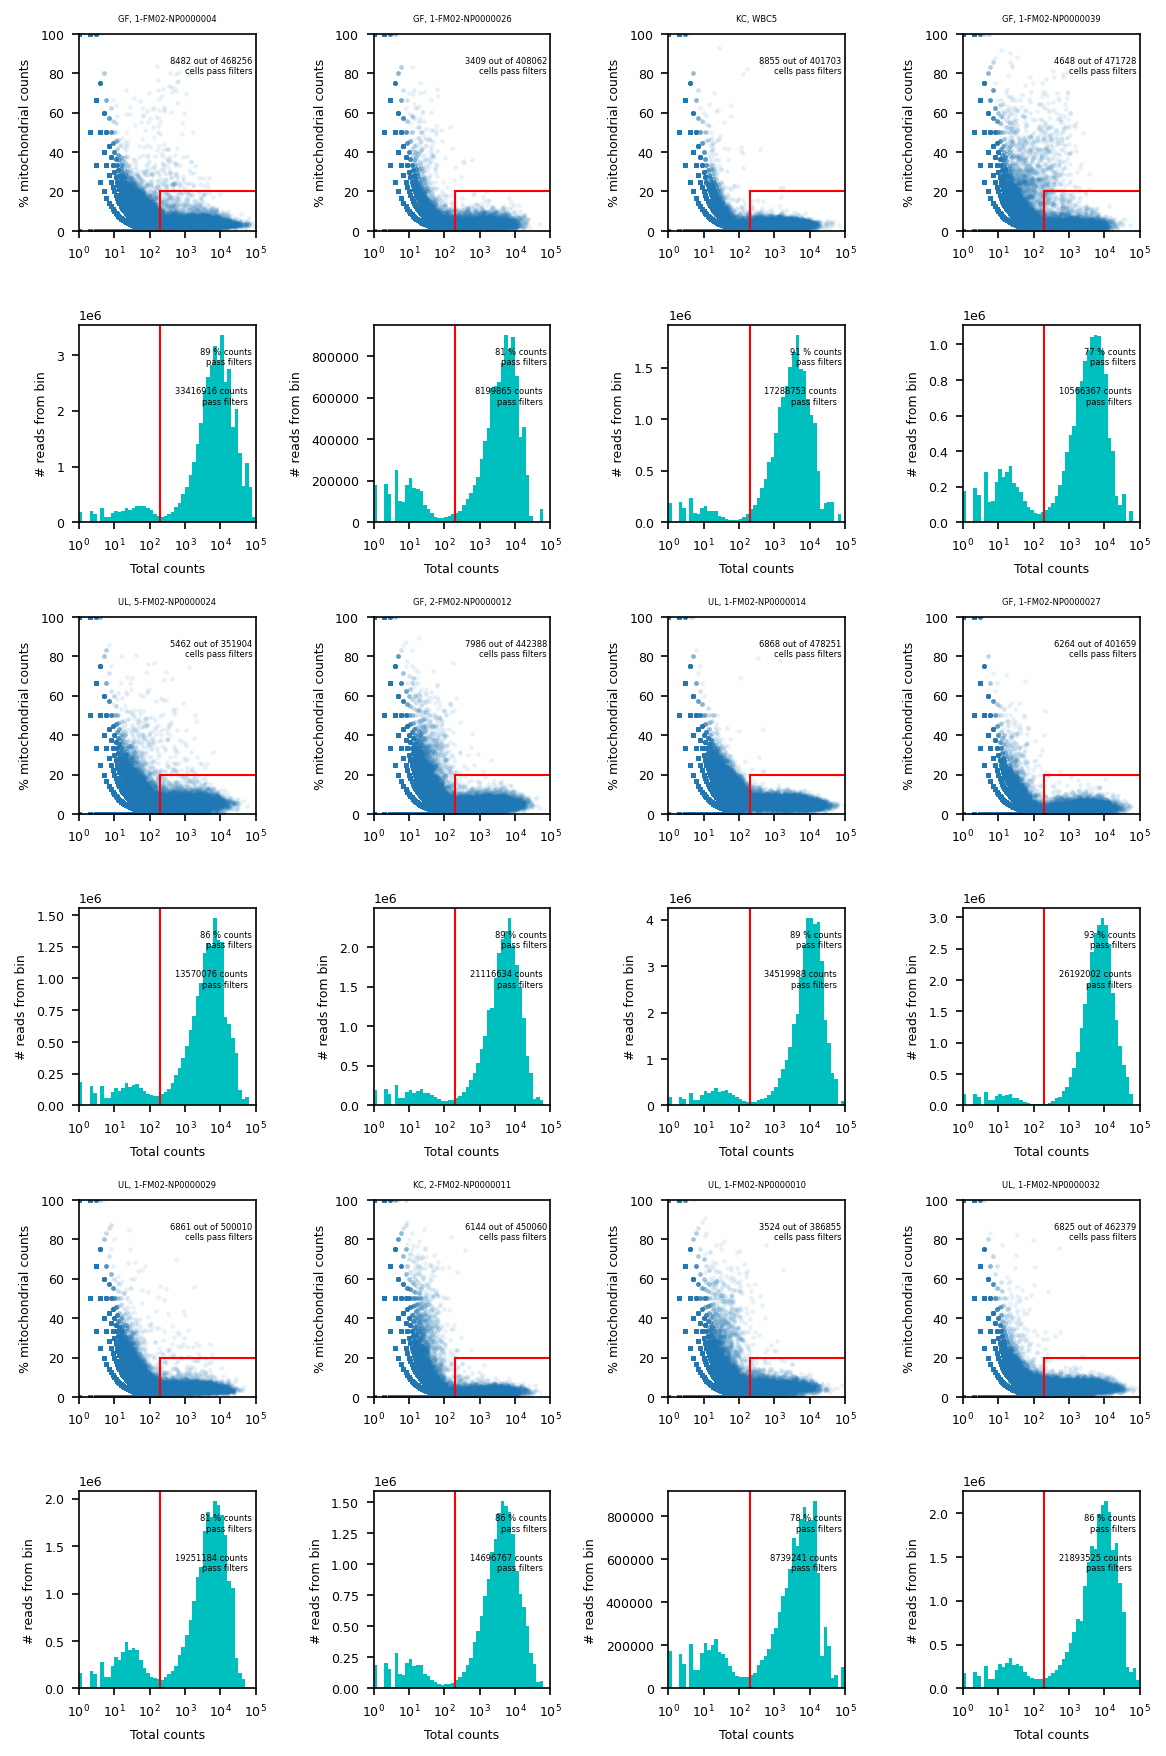

In [26]:
plt.rc('xtick', labelsize = 6)
plt.rc('ytick', labelsize = 6)

import math
pass_filters = []

#plot mito histograms
nr_rows = math.ceil(len(libs)/4.)

#nr_rows = 2

fig,gs = startfig(w=20,h=nr_rows*10,rows=nr_rows*2,columns=4,return_first_ax=False)
#startfig - a custom function by Rapo

#best way I could think of to get all the coordinates of the my subplots
coords = np.argwhere(np.zeros([nr_rows,4]) == 0)

# control total count range to expect
xmin = 1
xmax = 10**5

!mkdir -p outputs

for c,lib in zip(coords,libs):
    
    a = fig.add_subplot(gs[c[0]*2,c[1]])
    a1 = fig.add_subplot(gs[c[0]*2+1,c[1]])

    mask = adata.obs[libcol] == lib
    x = adata.obs.loc[mask,'total_counts']
    y = adata.obs.loc[mask,'pct_counts_mito']
    
    #scatter
    a.scatter(x,y,lw=0,s=5,alpha=0.1,rasterized=True)
    a.set_xscale('log')
    a.set_xlim(xmin,xmax)
    a.set_ylim(0,100)
    a.set_ylabel('% mitochondrial counts', fontsize = 6) #
    a.set_title(lib.replace(";", "\n"), fontsize = 4) #
    a.set_xticks([1, 10, 100, 1000, 10000, 100000])
    
    #plot threshold in scatter
    ts = ts_dict[lib]
    a.plot((ts[0],ts[0]),(a.get_ylim()[0],ts[1]),lw=1,color='r')
    a.plot((ts[0],a.get_xlim()[1]),(ts[1],ts[1]),lw=1,color='r')
    pass_ts = (adata.obs.loc[mask,'total_counts']>=ts[0])&(adata.obs.loc[mask,'pct_counts_mito']<ts[1])
    cells_pass = pass_ts.sum()
    cells_all = len(pass_ts)
    a.text(a.get_xlim()[1]*0.8,a.get_ylim()[1]*0.8,
           "%d out of %d\ncells pass filters"%(cells_pass,cells_all),
           ha='right', fontsize = 4) #
    pass_filters+=(list(pass_ts.values))
    
    # histogram
    bins=np.logspace(np.log10(xmin),np.log10(xmax),51)
    hs, bins,patches = plt.hist(x,bins=bins)
    
    #plot barchart
    lefts = bins[:-1]
    rights = bins[1:]
    a1.bar(x = lefts,width = rights-lefts,height = hs*rights,
          align='edge',
          lw=0.,color = 'c')
    a1.set_xscale('log');
    a1.set_xlim(xmin,xmax)
    # threshold:
    a1.plot((ts[0],ts[0]),(a1.get_ylim()[0],a1.set_ylim()[1]),lw=1,color='r')
    
    #a1.plot((2000,2000),(a1.get_ylim()[0],a1.set_ylim()[1]),lw=2,color='k')
    
    counts_pass_ts = (adata.obs.loc[mask,'total_counts']>=ts[0])&(adata.obs.loc[mask,'pct_counts_mito']<ts[1])
    counts_pass = sum(adata[mask][counts_pass_ts].obs.total_counts)
    counts_all = sum(adata[mask].obs.total_counts)
    a1.text(a1.get_xlim()[1]*0.8,a1.get_ylim()[1]*0.8,
           "%d %% counts\npass filters"%((counts_pass/counts_all)*100),
           ha='right', fontsize = 4) #   
    
    a1.text(a1.get_xlim()[1]*0.6,a1.get_ylim()[1]*0.6,
           "%d counts\npass filters"%((counts_pass)),
           ha='right', fontsize = 4) #  
    
    a1.set_xlabel('Total counts', fontsize = 6) #
    
    a1.set_ylabel('# reads from bin', fontsize = 6) #
    
    a1.set_xticks([1, 10, 100, 1000, 10000, 100000])
           

print(sum(pass_filters))
gs.tight_layout(fig)
!mkdir -p outputs
plt.savefig("outputs/240530_mito_pct_vs_total_counts_raw_condition_v2.png",dpi = 300)

# Apply the thesholds

In [27]:
cmask = np.repeat(True,adata.shape[0])

for key,value in ts_dict.items():
    m1 = (adata.obs[libcol] == key).values
    tmp = adata.obs[m1]
    m2 = (tmp["total_counts"]>=value[0]).values
    m3 = (tmp["pct_counts_mito"]<value[1]).values
    cmask[m1] = m2&m3
    
print(cmask.sum(),cmask.shape)

75328 (5223255,)


In [28]:
print(adata.shape)
adata = adata[cmask]
print(adata.shape)

(5223255, 37733)
(75328, 37733)


# Save the adata object

In [29]:
# directory
#!mkdir -p backups

# write the entire adata.object
start = time.time()
#fname1 = 'backups/mito_total_counts_filt_raw_%dx%d_%s.h5ad'%(adata.shape[0],adata.shape[1],now())
fname1 = home_dir+"/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/adatas/mito_total_counts_filt_raw_%dx%d_%s.h5ad"%(adata.shape[0],adata.shape[1],now())


print(fname1)
adata.write(fname1)
print(time.time()-start)

# write the pandas dataframe under adata.obs as a separate file
meta = adata.obs
#fname2 = 'backups/obs_info_raw_%dx%d_%s'%(meta.shape[0],meta.shape[1],now())
fname2 = home_dir+"/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/adatas/obs_info_raw_%dx%d_%s"%(meta.shape[0],meta.shape[1],now())
print(fname2)
save_df(meta,fname2)
print(time.time()-start)

/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/adatas/mito_total_counts_filt_raw_75328x37733_240530_13h57.h5ad


/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitMo

152.5013129711151
/Users/denis/NAS/data/240523_VH00558_558_AACJ2FKHV_trimmed_tso_PE/adatas/obs_info_raw_75328x16_240530_13h59
153.59194588661194
